In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from pathlib import Path
from typing import Optional, List
outputs_dir = Path("outputs_score")

In [2]:
df_a = pd.read_excel(outputs_dir/'results/ARIADNE_data.xlsx')
#  chrpsychs_scr_1d1 (severity) and chrpsychs_scr_1d2 (frequency).
df_eval = df_a[['interview_date','src_subject_id','chrpsychs_scr_1d1','chrpsychs_scr_1d2','visit']].copy()
df_eval = df_eval.iloc[1:].reset_index()
df_eval = df_eval.rename(columns={"chrpsychs_scr_1d1": "severity", "chrpsychs_scr_1d2": "frequency"})

In [3]:
def extract_subject_and_model(filename: str):
    """
    Extract subject ID, day, session, and model name from filenames like:
      PrescientBM_BM13061_interviewAudioTranscript_psychs_day0001_session001_REDACTED_assessment_Dom_v2_qwen3.txt
    Handles negative day numbers (e.g., day-117), and cleans model name (removes 'v2_' prefix).
    """
    # Extract subject ID (second underscore-separated token)
    parts = filename.split("_")
    subj = parts[1] if len(parts) > 1 else None

    # Extract day (may include negative sign)
    day_match = re.search(r"day-?\d+", filename)
    if day_match:
        # Extract the numeric value including sign
        day_str = re.search(r"-?\d+", day_match.group(0)).group(0)
        day = int(day_str)
    else:
        day = None
        print(f"Unmatched day: {filename}")

    # Extract session
    session_match = re.search(r"session-?\d+", filename)
    if session_match:
        session_str = re.search(r"-?\d+", session_match.group(0)).group(0)
        session = int(session_str)
    else:
        session = None
        print(f"Unmatched session: {filename}")

    # Extract model name (after last underscore in "assessment_*")
    model_match = re.search(r"assessment_[^_]+_([^./]+)", filename)
    model = model_match.group(1) if model_match else "unknown"

    # Clean model prefix like v2_ or Dom_v3_
    model = re.sub(r"^v\d+_", "", model)
    model = re.sub(r"^Dom_v\d+_", "", model)

    return subj, day, session, model

def extract_score(text,label):
    """
    Extracts severity and frequency scores from structured model outputs.
    Handles presence of only one score block gracefully.
    """
    def find_value(label):
        # Match any digits (with optional decimal) between begin/end markers
        pattern = rf"\[{label}_BEGINS:?\]\s*([\d.]+)\s*\[/{label}_ENDS\]"
        m = re.search(pattern, text, flags=re.IGNORECASE | re.DOTALL)
        if m:
            try:
                return float(m.group(1))
            except ValueError:
                return None
        return None

    score = find_value(label)

    return score

In [5]:

records = []
target_model = "gpt-oss:20b"      # e.g., "qwen3", "gpt-oss:20b", or "all"
prompt_name = "Alejo_freq"      # e.g., "Dom_v2", "Dom_v3", etc.

# Flexible glob pattern: model and prompt both optional
pattern = "*assessment_"
pattern += f"{prompt_name}_"
pattern += f"{target_model}"
pattern += ".txt"

print(f"\n🔍 Searching for files matching: {pattern}")

for f in outputs_dir.glob(pattern):
    text = f.read_text(encoding="utf-8", errors="ignore")

    subj, day, session, model = extract_subject_and_model(f.name)
    # sev = extract_score(text,"ESTIMATED_SEVERITY")
    freq = extract_score(text,"ESTIMATED_FREQUENCY")

    
    if freq == None:
        print('File of texts with nan values parsed: ')
        print(f)

    records.append({
        "src_subject_id": subj,
        "day": day,
        "session": session,
        "model": model,
        "prompt": prompt_name,
        # "severity_pred": sev,
        "frequency_pred":freq
    })

df_pred = pd.DataFrame(records)
print(f"\n📄 Extracted {len(df_pred)} predictions (model={target_model}, prompt={prompt_name})")
print(df_pred.head())

out_file = outputs_dir / f"results/score_pred_{prompt_name}_{target_model}.csv"

# Save only if file does not already exist
if not out_file.exists():
    df_pred.to_csv(out_file, index=False)
    print(f"✅ Saved: {out_file}")
else:
    print(f"⚠️ File already exists, not overwritten: {out_file}")


🔍 Searching for files matching: *assessment_Alejo_freq_gpt-oss:20b.txt
File of texts with nan values parsed: 
outputs_score/PrescientME_ME63249_interviewAudioTranscript_psychs_day0001_session001_REDACTED_assessment_Alejo_freq_gpt-oss:20b.txt
File of texts with nan values parsed: 
outputs_score/PrescientME_ME60881_interviewAudioTranscript_psychs_day0050_session002_REDACTED_assessment_Alejo_freq_gpt-oss:20b.txt
File of texts with nan values parsed: 
outputs_score/PrescientME_ME63950_interviewAudioTranscript_psychs_day0002_session001_REDACTED_assessment_Alejo_freq_gpt-oss:20b.txt
File of texts with nan values parsed: 
outputs_score/PrescientSG_SG36292_interviewAudioTranscript_psychs_day0045_session002_REDACTED_assessment_Alejo_freq_gpt-oss:20b.txt
File of texts with nan values parsed: 
outputs_score/PrescientME_ME10086_interviewAudioTranscript_psychs_day0052_session002_REDACTED_assessment_Alejo_freq_gpt-oss:20b.txt
File of texts with nan values parsed: 
outputs_score/PronetWU_WU24843_int

In [5]:
# add manual scores for qwen 3
# df_pred.loc[df_pred['src_subject_id'] == 'SG71850', 'frequency_pred'] = 5
# df_pred.loc[((df_pred['src_subject_id'] == 'ME19909')&(df_pred['day']==72)), 'frequency_pred'] = 0
# df_pred.loc[((df_pred['src_subject_id'] == 'PI26395')&(df_pred['day']==16)&(df_pred['session']==2)), 'frequency_pred'] = 0
# df_pred.loc[((df_pred['src_subject_id'] == 'PI26395')&(df_pred['day']==16)&(df_pred['session']==2)), 'severity_pred'] = 0

In [6]:
# Define target columns
cols = ["severity_pred"]

# Filter rows where either column is NaN
nan_rows = df_pred[df_pred[cols].isna().any(axis=1)]

# Print summary and rows
print(f"🔍 Found {len(nan_rows)} rows with missing severity or frequency scores.\n")
print(nan_rows.to_string(index=False))

df_pred[cols] = df_pred[cols].fillna(0)

KeyError: "None of [Index(['severity_pred'], dtype='object')] are in the [columns]"

In [12]:
# Subset each DataFrame
df_pred_day1 = df_pred[df_pred["day"] == 1]
df_eval_baseline = df_eval[df_eval["visit"] == "baseline"]

# Merge on subject ID
df_merged_day1 = pd.merge(
    df_pred_day1,
    df_eval_baseline,
    on="src_subject_id",
    how="inner"   # only subjects present in both
)

print(f"✅ Merged {len(df_merged_day1)} rows (day=1 × baseline).")
print(df_merged_day1.head())

out_file = outputs_dir / f"results/score_baseline_{prompt_name}_{target_model}.csv"

# Save only if file does not already exist
if not out_file.exists():
    df_merged_day1.to_csv(out_file, index=False)
    print(f"✅ Saved: {out_file}")
else:
    print(f"⚠️ File already exists, not overwritten: {out_file}")

✅ Merged 201 rows (day=1 × baseline).
  src_subject_id  day  session       model      prompt  frequency_pred  index  \
0        YA16606    1        2  freq_qwen3  Alejo_freq             0.0   3298   
1        ME12795    1        1  freq_qwen3  Alejo_freq             1.0   1236   
2        WU14773    1        1  freq_qwen3  Alejo_freq             NaN   3915   
3        NC00474    1        1  freq_qwen3  Alejo_freq             0.0   2557   
4        YA67699    1        1  freq_qwen3  Alejo_freq             NaN   3448   

        interview_date severity frequency     visit  
0           04/26/2023        0         0  baseline  
1           12/27/2023        2         2  baseline  
2           08/31/2023        4         3  baseline  
3           10/25/2022        0         0  baseline  
4  2024-11-07 00:00:00        3         2  baseline  
✅ Saved: outputs_score/results/score_baseline_Alejo_freq_qwen3.csv


## Results analysis

In [13]:
target_model = "qwen3"
out_file = outputs_dir / f"results/score_baseline_{prompt_name}_{target_model}.csv"
df = pd.read_csv(out_file)
gt_sev_col = "severity"
gt_freq_col = "frequency"
pred_sev_col = "severity_pred"
pred_freq_col = "frequency_pred"

✅ Remaining rows for analysis: 160
        frequency  frequency_pred
count  160.000000      160.000000
mean     2.112500        1.975000
std      1.787404        1.737308
min      0.000000        0.000000
25%      0.000000        0.000000
50%      2.000000        2.000000
75%      3.000000        3.000000
max      6.000000        6.000000

📊 Correlation summary for Severity:
  Pearson r = 0.315 (p=0.0001)
  Spearman ρ = 0.322 (p=0.0000)
  Kendall τ = 0.258 (p=0.0000)


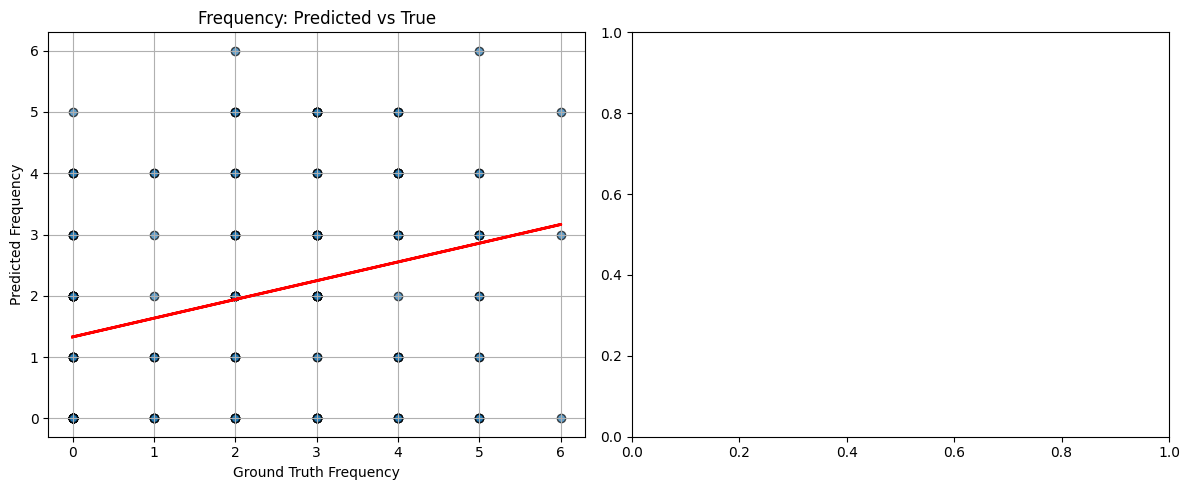

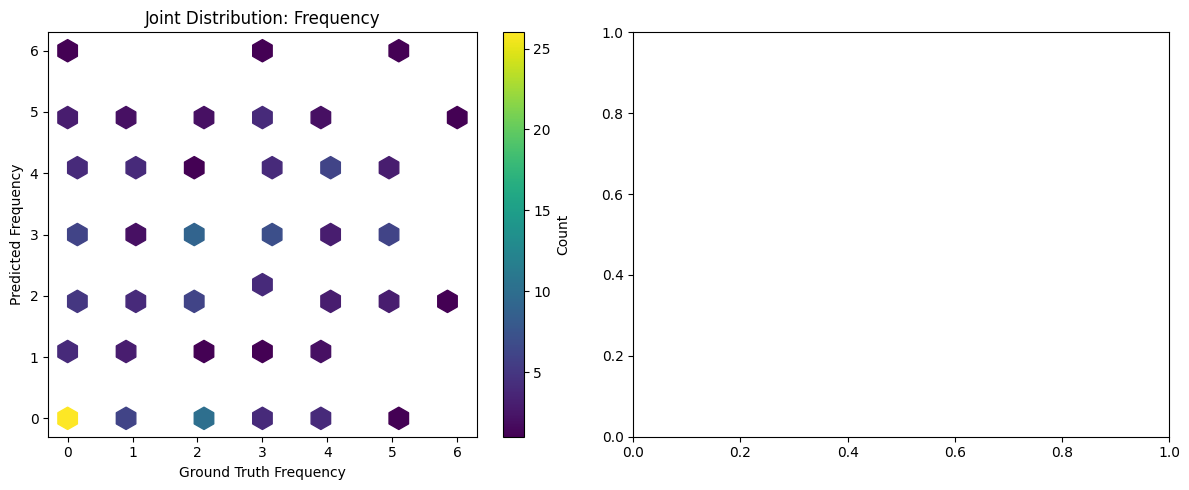

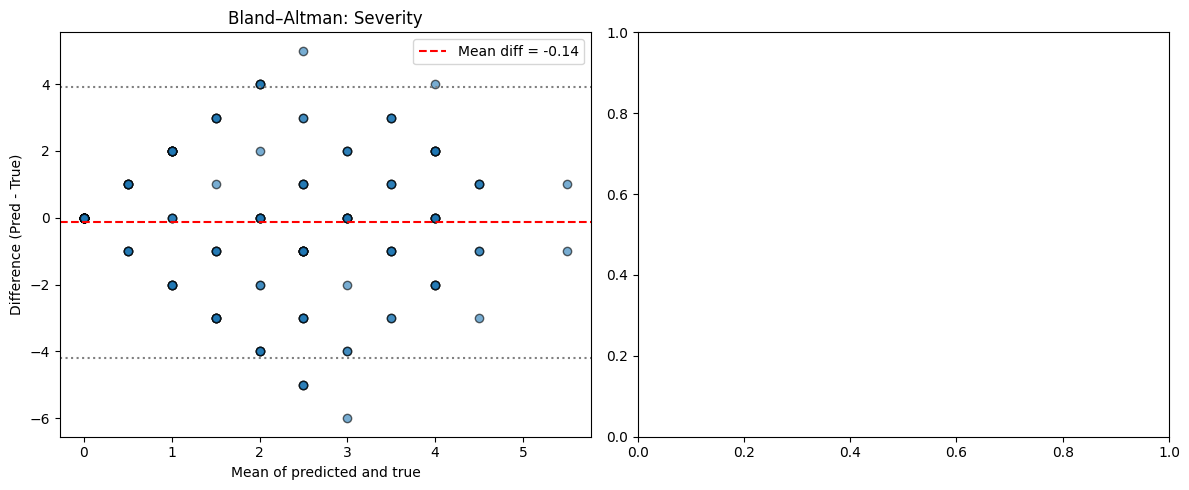

In [15]:
# DATA CLEANING
# =============================================

cols_to_fix = [gt_freq_col, pred_freq_col]

# Convert to numeric, forcing invalid strings (like "NA") to NaN
for c in cols_to_fix:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Keep only rows with all four valid numeric values
df = df.dropna(subset=cols_to_fix)

# Restrict to CAARMS scale (0–6) to avoid outliers like 2023
for c in cols_to_fix:
    df.loc[~df[c].between(0, 6, inclusive="both"), c] = np.nan

df = df.dropna(subset=cols_to_fix)

print(f"✅ Remaining rows for analysis: {len(df)}")
print(df[cols_to_fix].describe())

# =============================================
# CORRELATION ANALYSIS
# =============================================

def corr_summary(x, y, label):
    """Compute Pearson, Spearman, and Kendall correlations."""
    pearson_r, p_p = pearsonr(x, y)
    spearman_r, p_s = spearmanr(x, y)
    kendall_r, p_k = kendalltau(x, y)
    print(f"\n📊 Correlation summary for {label}:")
    print(f"  Pearson r = {pearson_r:.3f} (p={p_p:.4f})")
    print(f"  Spearman ρ = {spearman_r:.3f} (p={p_s:.4f})")
    print(f"  Kendall τ = {kendall_r:.3f} (p={p_k:.4f})")

corr_summary(df[cols_to_fix[0]], df[cols_to_fix[1]], "Frequency")


# =============================================
# SCATTER + REGRESSION PLOTS
# =============================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (xcol, ycol, label) in zip(
    axes,
    [(cols_to_fix[0], cols_to_fix[1], "Frequency")]
):
    ax.scatter(df[xcol], df[ycol], alpha=0.7, edgecolor="k")
    ax.set_xlabel(f"Ground Truth {label}")
    ax.set_ylabel(f"Predicted {label}")
    ax.set_title(f"{label}: Predicted vs True")
    # Regression line
    m, b = np.polyfit(df[xcol], df[ycol], 1)
    ax.plot(df[xcol], m * df[xcol] + b, color="red", linewidth=2)
    ax.grid(True)

plt.tight_layout()
plt.show()

# =============================================
# HEXBIN DENSITY PLOTS
# =============================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, (pred, gt, title) in zip(
    axes,
    [(cols_to_fix[0], cols_to_fix[1], "Frequency")]
):
    hb = ax.hexbin(df[gt], df[pred], gridsize=20, cmap="viridis", mincnt=1)
    ax.set_xlabel(f"Ground Truth {title}")
    ax.set_ylabel(f"Predicted {title}")
    ax.set_title(f"Joint Distribution: {title}")
    fig.colorbar(hb, ax=ax, label="Count")

plt.tight_layout()
plt.show()

# =============================================
# BLAND–ALTMAN PLOTS
# =============================================

def bland_altman_plot(x, y, ax, title):
    diff = y - x
    mean = (x + y) / 2
    md = diff.mean()
    sd = diff.std()
    ax.scatter(mean, diff, alpha=0.6, edgecolor="k")
    ax.axhline(md, color="red", linestyle="--", label=f"Mean diff = {md:.2f}")
    ax.axhline(md + 1.96*sd, color="gray", linestyle=":")
    ax.axhline(md - 1.96*sd, color="gray", linestyle=":")
    ax.set_xlabel(f"Mean of predicted and true")
    ax.set_ylabel("Difference (Pred - True)")
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
bland_altman_plot(df[cols_to_fix[0]], df[cols_to_fix[1]], axes[0], "Bland–Altman: Severity")
plt.tight_layout()
plt.show()
# %%

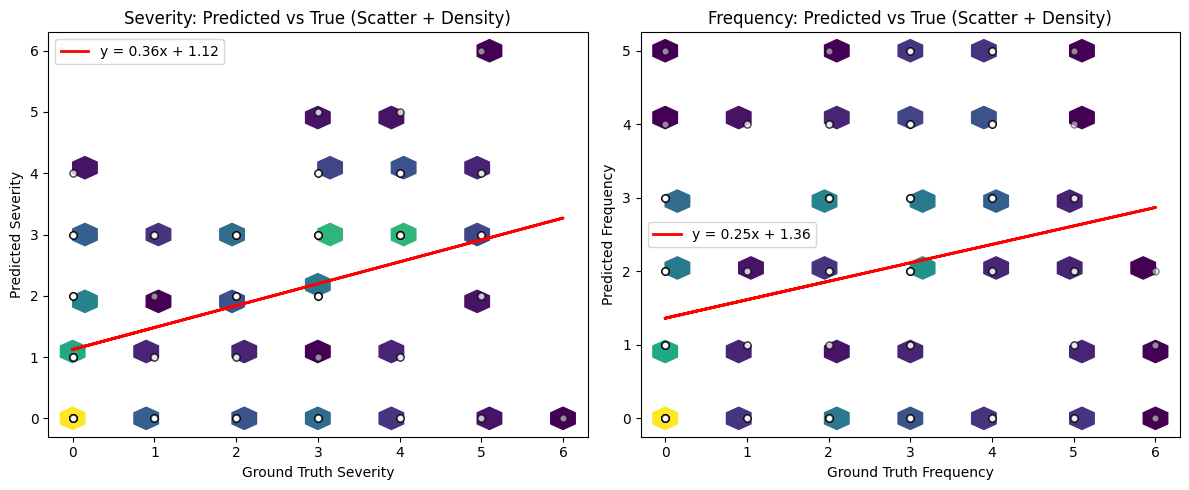

In [16]:

# Helper function to add regression line
def plot_regression(ax, x, y, color="red"):
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m * x + b, color=color, lw=2, label=f"y = {m:.2f}x + {b:.2f}")
    ax.legend()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plt.subplots_adjust(wspace=0.3)

# -------- Severity subplot --------
ax = axes[0]
ax.hexbin(df[gt_sev_col], df[pred_sev_col], gridsize=20, cmap="viridis", mincnt=1)
ax.scatter(df[gt_sev_col], df[pred_sev_col], alpha=0.5, color="white", edgecolor="k", s=25)
plot_regression(ax, df[gt_sev_col], df[pred_sev_col])
ax.set_xlabel("Ground Truth Severity")
ax.set_ylabel("Predicted Severity")
ax.set_title("Severity: Predicted vs True (Scatter + Density)")

# -------- Frequency subplot --------
ax = axes[1]
ax.hexbin(df[gt_freq_col], df[pred_freq_col], gridsize=20, cmap="viridis", mincnt=1)
ax.scatter(df[gt_freq_col], df[pred_freq_col], alpha=0.5, color="white", edgecolor="k", s=25)
plot_regression(ax, df[gt_freq_col], df[pred_freq_col])
ax.set_xlabel("Ground Truth Frequency")
ax.set_ylabel("Predicted Frequency")
ax.set_title("Frequency: Predicted vs True (Scatter + Density)")

plt.tight_layout()
plt.show()